<a href="https://colab.research.google.com/github/PaatriickC/CSCI-166-Project/blob/main/CSCI166SpaceInvadersDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations / Imports

In [1]:
# === Installs ===
!pip install --quiet gymnasium[atari,accept-rom-license]
!pip install --quiet autorom
!pip install --quiet stable-baselines3

!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [2]:
import ale_py
import gymnasium as gym

In [3]:
# === Imports & basic setup ===
import os
import time
import collections
import typing as tt
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from gymnasium import spaces
from stable_baselines3.common import atari_wrappers

from torch.utils.tensorboard.writer import SummaryWriter

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Model

In [4]:
# === Model: DQN conv head -> |A| ===
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        # lazy compute flattened size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            size = self.conv(dummy).shape[-1]

        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x: torch.Tensor):
        # x expected as ByteTensor in [0,255]
        x = x.float() / 255.0
        return self.fc(self.conv(x))


# Observation Wrappers

In [5]:
# === Observation Wrappers (ImageToPyTorch, BufferWrapper) and env maker ===
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, spaces.Box) and len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict] = None):
        # fill initial buffer with zeros
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env


# Hyperparameters & fast-debug config

In [6]:
# === Hyperparameters & fast-debug config ===
DEFAULT_ENV_NAME = "ALE/SpaceInvaders-v5"
MEAN_REWARD_BOUND = 100  # placeholder; for full training tune this

GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 50_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 5_000
REPLAY_START_SIZE = 10_000

SAVE_EPSILON = 0.1
EPSILON_DECAY_LAST_FRAME = 300_000
EPSILON_START = 1.0
EPSILON_FINAL = 0.05

TOTAL_FRAMES = 1_000_000

# Experience

In [7]:
# === Experience dataclass, buffer, Agent (with bugfix), batch helpers, loss ===
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,  # current state
    torch.LongTensor,  # actions
    torch.Tensor,      # rewards
    torch.BoolTensor,  # done/trunc
    torch.ByteTensor    # next state
]

@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State

class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            # BUGFIX: use self.env (not env variable)
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state, device=device)  # shape (C,H,W*n_steps)
            state_v = state_v.unsqueeze(0)  # add batch
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        new_state, reward, terminated, truncated, _ = self.env.step(action)
        self.total_reward += float(reward)

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=terminated or truncated, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if terminated or truncated:
            done_reward = self.total_reward
            self._reset()
        return done_reward

def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_states = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_states.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states), dtype=torch.uint8, device=device)
    actions_t = torch.as_tensor(actions, dtype=torch.long, device=device)
    rewards_t = torch.as_tensor(rewards, dtype=torch.float32, device=device)
    dones_t = torch.as_tensor(dones, dtype=torch.bool, device=device)
    new_states_t = torch.as_tensor(np.asarray(new_states), dtype=torch.uint8, device=device)
    return states_t, actions_t, rewards_t, dones_t, new_states_t

def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0

    expected_state_action_values = rewards_t + GAMMA * next_state_values
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Setup envs, nets, buffer, agent, optimizaer, training loop

In [8]:
# === Directories ===
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# === device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === environment and networks ===
env_name = DEFAULT_ENV_NAME
env = make_env(env_name)

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net.load_state_dict(net.state_dict())

print(net)

# === Summary writer ===
model_comment = f"spaceinvaders_fastdebug_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
writer = SummaryWriter(comment=f"-{env_name}-{model_comment}")

# === buffer, agent, optimizer ===
buffer = ExperienceBuffer(REPLAY_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# === training bookkeeping ===
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_m_reward = None

start_time = time.time()

# === Main training loop ===
while True:
    frame_idx += 1
    epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

    reward = agent.play_step(net, device, epsilon)
    if reward is not None:
        total_rewards.append(reward)
        speed = (frame_idx - ts_frame) / (time.time() - ts + 1e-8)
        elapsed = time.time() - start_time
        ts_frame = frame_idx
        ts = time.time()
        m_reward = np.mean(total_rewards[-100:])
        writer.add_scalar("epsilon", epsilon, frame_idx)
        writer.add_scalar("speed", speed, frame_idx)
        writer.add_scalar("reward_100", m_reward, frame_idx)
        writer.add_scalar("reward", reward, frame_idx)

        if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
            print(f"{frame_idx}: done {len(total_rewards)} games, reward {m_reward:.3f}, eps {epsilon:.3f}, speed {speed:.2f} f/s, time {elapsed/60:.2f} min")
            timestamp = datetime.now().strftime("%Y%m%d-%H%M")
            safe_env_name = env_name.replace("/", "_")
            model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

            model_path_drive = os.path.join(save_dir_drive, model_filename)
            model_path_local = os.path.join(save_dir_local, model_filename)

            torch.save(net.state_dict(), model_path_drive)
            torch.save(net.state_dict(), model_path_local)

            print(f"💾 Model saved to:\n - Google Drive: {model_path_drive}\n - Local:        {model_path_local}")
            if best_m_reward is not None:
                print(f"Best reward updated {best_m_reward:.3f} -> {m_reward:.3f}")
            best_m_reward = m_reward

        if m_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    # wait until buffer has enough samples
    if len(buffer) < REPLAY_START_SIZE:
        continue

    # sync target periodically
    if frame_idx % SYNC_TARGET_FRAMES == 0:
        tgt_net.load_state_dict(net.state_dict())

    # sample batch and optimize
    optimizer.zero_grad()
    batch = buffer.sample(BATCH_SIZE)
    loss_t = calc_loss(batch, net, tgt_net, device)
    loss_t.backward()
    optimizer.step()

# cleanup
env.close()
writer.close()

Creating environment ALE/SpaceInvaders-v5
DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


39: done 1 games, reward 40.000, eps 1.000, speed 341.35 f/s, time 0.00 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_SpaceInvaders-v5-best_40-20251201-0143-spaceinvaders_fastdebug_epsdec300000_rs10000_sync5000.dat
 - Local:        saved_models/ALE_SpaceInvaders-v5-best_40-20251201-0143-spaceinvaders_fastdebug_epsdec300000_rs10000_sync5000.dat
55: done 2 games, reward 42.500, eps 1.000, speed 200.41 f/s, time 0.00 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_SpaceInvaders-v5-best_42-20251201-0143-spaceinvaders_fastdebug_epsdec300000_rs10000_sync5000.dat
 - Local:        saved_models/ALE_SpaceInvaders-v5-best_42-20251201-0143-spaceinvaders_fastdebug_epsdec300000_rs10000_sync5000.dat
Best reward updated 40.000 -> 42.500
553: done 15 games, reward 44.667, eps 0.998, speed 346.77 f/s, time 0.03 min
💾 Model saved to:
 - Google Drive: /content/drive/MyDrive/PUBLIC/Models/ALE_SpaceInvaders-v5-best_44-20251201-0143-spaceinvad

# Experimentation, Logging, Learning Curves, and Video Recording

In [9]:
import os, csv, json
from pathlib import Path
import matplotlib.pyplot as plt
experiment_log = []
experiment_dir = Path('experiments'); experiment_dir.mkdir(exist_ok=True)
videos_dir = Path('videos'); videos_dir.mkdir(exist_ok=True)
videos_early_dir = videos_dir/'early'; videos_late_dir = videos_dir/'late'
videos_early_dir.mkdir(parents=True, exist_ok=True); videos_late_dir.mkdir(parents=True, exist_ok=True)

def current_setting():
    return {
        'env': DEFAULT_ENV_NAME,
        'GAMMA': GAMMA,
        'BATCH_SIZE': BATCH_SIZE,
        'REPLAY_SIZE': REPLAY_SIZE,
        'LEARNING_RATE': LEARNING_RATE,
        'SYNC_TARGET_FRAMES': SYNC_TARGET_FRAMES,
        'REPLAY_START_SIZE': REPLAY_START_SIZE,
        'EPSILON_DECAY_LAST_FRAME': EPSILON_DECAY_LAST_FRAME,
        'timestamp': datetime.now().strftime('%Y%m%d-%H%M%S'),
    }

def save_experiment_log(log_list, filename='experiment_log.csv'):
    if not log_list: return
    keys = list(log_list[0].keys())
    out = experiment_dir/filename
    with open(out, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=keys); writer.writeheader()
        for row in log_list: writer.writerow(row)
    print('Saved experiment log to', out)


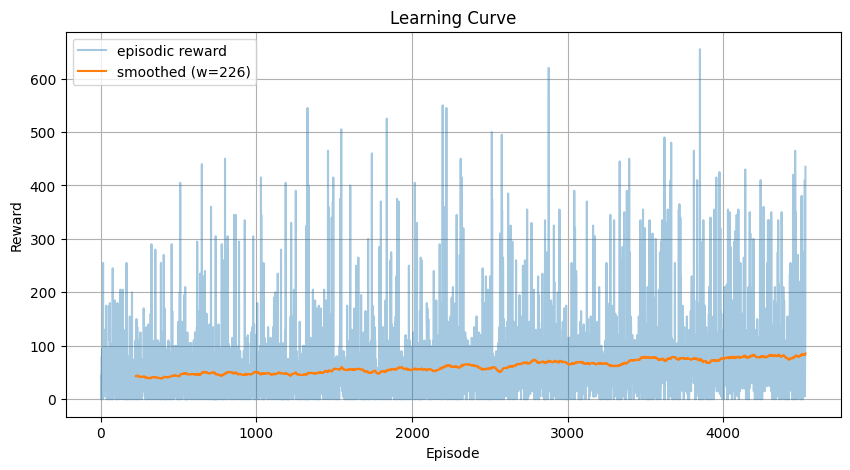

In [10]:
# === Learning Curve ===
import numpy as np
if 'total_rewards' in globals():
    ep_rewards = np.asarray(total_rewards)
    plt.figure(figsize=(10,5))
    plt.plot(ep_rewards, label='episodic reward', alpha=0.4)
    if len(ep_rewards) > 5:
        w = max(5, len(ep_rewards)//20)
        sm = np.convolve(ep_rewards, np.ones(w)/w, mode='valid')
        plt.plot(range(w-1, w-1+len(sm)), sm, label=f'smoothed (w={w})')
    plt.legend(); plt.grid(); plt.title('Learning Curve'); plt.xlabel('Episode'); plt.ylabel('Reward')
    plt.show()
else:
    print('total_rewards not found')


In [11]:
# === Video Recording Utilities ===
import gymnasium as gym

def record_video(env_name, policy_net, device, save_dir, prefix='policy', max_frames=1800):
    env = make_env(env_name, render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, video_folder=str(save_dir), name_prefix=prefix)
    s, _ = env.reset(); frames = 0; done=False; trunc=False
    while frames < max_frames and not (done or trunc):
        state_v = torch.tensor(s, device=device).unsqueeze(0)
        with torch.no_grad():
            q = policy_net(state_v); a = int(torch.argmax(q, dim=1))
        s, _, done, trunc, _ = env.step(a); frames+=1
    env.close(); print('Saved video to', save_dir)

def record_random(env_name, save_dir, prefix='random', max_frames=1800):
    env = make_env(env_name, render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(env, video_folder=str(save_dir), name_prefix=prefix)
    s,_ = env.reset(); frames=0; done=False; trunc=False
    while frames < max_frames and not (done or trunc):
        a = env.action_space.sample()
        s,_,done,trunc,_ = env.step(a); frames+=1
    env.close(); print('Saved random video to', save_dir)


In [12]:
# Record early and late videos
record_random(DEFAULT_ENV_NAME, videos_early_dir)
record_video(DEFAULT_ENV_NAME, net, device, videos_late_dir)


Creating environment ALE/SpaceInvaders-v5


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos/early folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Saved random video to videos/early
Creating environment ALE/SpaceInvaders-v5


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos/late folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Saved video to videos/late


In [13]:
# Add experiment entry
entry = current_setting(); entry['final_mean_reward']=float(np.mean(total_rewards[-100:])) if len(total_rewards)>0 else None
experiment_log.append(entry)
save_experiment_log(experiment_log)
print(entry)


Saved experiment log to experiments/experiment_log.csv
{'env': 'ALE/SpaceInvaders-v5', 'GAMMA': 0.99, 'BATCH_SIZE': 32, 'REPLAY_SIZE': 50000, 'LEARNING_RATE': 0.0001, 'SYNC_TARGET_FRAMES': 5000, 'REPLAY_START_SIZE': 10000, 'EPSILON_DECAY_LAST_FRAME': 300000, 'timestamp': '20251201-021123', 'final_mean_reward': 101.85}
